# GPU Test

In [7]:
from tensorflow.python.client import device_lib
print (device_lib.list_local_devices())
import tensorflow as tf
with tf.device('/gpu:0'):
    a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
    b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
    c = tf.matmul(a, b)

with tf.Session() as sess:
    print (sess.run(c))

[name: "/cpu:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1656504204908198190
, name: "/gpu:0"
device_type: "GPU"
memory_limit: 1561654067
locality {
  bus_id: 1
}
incarnation: 8902611138554513978
physical_device_desc: "device: 0, name: GeForce GTX 750 Ti, pci bus id: 0000:01:00.0"
]
[[ 22.  28.]
 [ 49.  64.]]


# Read in Data

In [8]:
import pandas as pd
import numpy as np
import csv
from sklearn.model_selection import train_test_split


path = './data/'

lines =[]
with open(path+'driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        lines.append(line)

train_lines, validation_lines = train_test_split(lines[1:], test_size=0.2)

#reader = pd.read_csv(path+'driving_log.csv')
#column_center_images = reader.loc[: , "center"]
#column_left_images = reader.loc[: , "left"]
#column_right_images = reader.loc[: , "right"]
#column_steering_angles = reader.loc[: , "steering"]
#center_train, center_valid, left_train, left_valid, right_train, right_valid, steering_train, steering_valid =\
#train_test_split(column_center_images, column_left_images,\
#                   column_right_images, column_steering_angles, test_size=0.2)


# OBsolete Code

# Model Implementation

Using TensorFlow backend.


Epoch 1/10
15020/15020 [==============================] - 92s - loss: 0.0652 - acc: 0.3726 - val_loss: 0.0504 - val_acc: 0.3775
Epoch 2/10
15020/15020 [==============================] - 42s - loss: 0.0568 - acc: 0.3727 - val_loss: 0.0445 - val_acc: 0.3775
Epoch 3/10
15020/15020 [==============================] - 42s - loss: 0.0526 - acc: 0.3721 - val_loss: 0.0439 - val_acc: 0.3775
Epoch 4/10
15020/15020 [==============================] - 42s - loss: 0.0516 - acc: 0.3721 - val_loss: 0.0409 - val_acc: 0.3775
Epoch 5/10
15020/15020 [==============================] - 42s - loss: 0.0495 - acc: 0.3722 - val_loss: 0.0400 - val_acc: 0.3775
Epoch 6/10
15020/15020 [==============================] - 42s - loss: 0.0465 - acc: 0.3724 - val_loss: 0.0388 - val_acc: 0.3775
Epoch 7/10
15020/15020 [==============================] - 45s - loss: 0.0450 - acc: 0.3720 - val_loss: 0.0387 - val_acc: 0.3778
Epoch 8/10
15020/15020 [==============================] - 43s - loss: 0.0418 - acc: 0.3730 - val_loss: 0

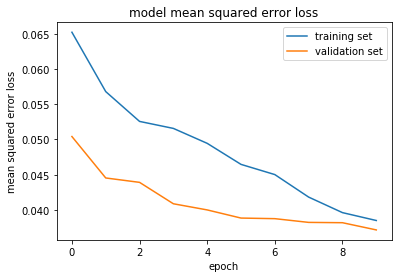

In [9]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten, Dropout, Lambda
from keras.layers import Cropping2D
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
import matplotlib.pyplot as plt
import sklearn
import cv2
import os
import sys

steering_correction = 0.3

def generator(samples, batch_size=32):
    num_samples = len(samples)
    #print (num_samples)
    while 1: # Loop forever so the generator never terminates
        sklearn.utils.shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]
            all_images = []
            steering_measurements = []
            for batch_sample in batch_samples:
                #print (batch_sample)
                filename = os.path.basename(batch_sample[0])
                image = cv2.imread(path+'IMG/'+filename)
                all_images.append(image)
                all_images.append(cv2.flip(image,1))
                measurement = float(batch_sample[3])
                steering_measurements.append(measurement)
                steering_measurements.append(measurement*-1.0)
                filename = os.path.basename(batch_sample[1])
                image = cv2.imread(path+'IMG/'+filename)
                all_images.append(image)
                filename = os.path.basename(batch_sample[2])
                image = cv2.imread(path+'IMG/'+filename)
                all_images.append(image)
                steering_measurements.append(measurement+steering_correction)
                steering_measurements.append(measurement-steering_correction)
                #print(i, batch_size, offset, num_samples)
            X_train = np.array(all_images)
            # Convert the image from BGR to RGB format. Thanks for finding the bug in my code!
            X_train = X_train[...,::-1]
            y_train = np.array(steering_measurements)
            yield sklearn.utils.shuffle(X_train, y_train)
            
# compile and train the model using the generator function
train_generator = generator(train_lines, batch_size=32)
validation_generator = generator(validation_lines, batch_size=32)

model = Sequential()
# Preprocess incoming data, centered around zero with small standard deviation 
model.add(Cropping2D(cropping=((50,20), (0,0)), input_shape=(160,320,3)))
model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=(90,320,3)))
model.add(Convolution2D(24, 5, 5, subsample=(2, 2,), border_mode='valid', activation='relu'))
model.add(Convolution2D(36, 5, 5, subsample=(2, 2,), activation='relu'))
model.add(Convolution2D(48, 5, 5, subsample=(2, 2,), activation='relu'))
model.add(Convolution2D(64, 3, 3, subsample=(1, 1,), activation='relu'))
model.add(Convolution2D(64, 3, 3, subsample=(1, 1,), activation='relu'))
#model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(100))
model.add(Dropout(0.50))
model.add(Dense(50))
model.add(Dropout(0.50))
model.add(Dense(10))
model.add(Dropout(0.50))
model.add(Dense(1))
#model.add(Activation('softmax'))

model.compile(loss='mse', optimizer='adam', metrics = ['accuracy'])
history_object = model.fit_generator(train_generator, samples_per_epoch= 4*len(train_lines), \
                    validation_data=validation_generator, nb_val_samples= 4*len(validation_lines),\
                    nb_epoch=10, verbose = 1)
model.save('model.h5')

print(history_object.history.keys())
### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

In [6]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')

ImportError: cannot import name 'plot_model'

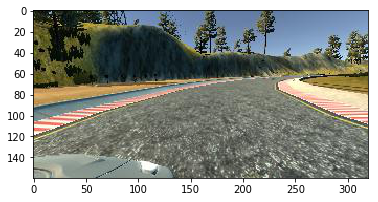

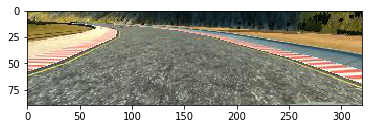

In [6]:
import matplotlib.image as mpimg
import cv2
import matplotlib.pyplot as plt
import numpy as np

image_demo = cv2.imread('figures/left_image.jpg')
#image_demo = mpimg.imread('figures/center_image.jpg')
image_demo = np.array(image_demo)
image_demo = image_demo[...,::-1]
plt.imshow(cv2.flip(image_demo,1))
plt.show()
image_demo_crop = image_demo[50:140, 0:320]
plt.imshow(image_demo_crop)
plt.show()